## Notebook to explore how to customise colours of protein surface representations

In [1]:
import nglview as nv
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np

## Prepare data

In [2]:
def getFlynn(assay="fret", sep="\t"):
    # flynn et al
    scores_df = pd.read_csv(f"../data/{assay}_1_flynn_et_al.csv", sep=sep)
    try:
        scores_df = scores_df[scores_df[" aa"] != "*"] # exclude functional stops
    except KeyError:
        scores_df = scores_df[scores_df["aa"] != "*"] # exclude functional stops

    # there may be some residues missing from the DF. Find them so we can fill with nans.
    residues = list(scores_df.groupby(by="Position").groups.keys())
    missing_residues = list(set(range(residues[0], residues[-1]+1)) - set(residues))
    for res in missing_residues:
        # insert each residue with nans; have to keep sorting index to keep appending.
        scores_df.loc[len(scores_df)] = [res, "nan", "nan", "nan", "nan"]
        scores_df.index = scores_df.index + 1
        scores_df = scores_df.sort_index()
    # finally sort again to restore df to initial sorting.
    scores_df = scores_df.sort_values(by="Position")

    # squash per residue using mean. might have to change this later bc
    # ceil/floor of arrays is more important in mutations?
    fn_scores = []
    for residue_number, data in scores_df.groupby(by="Position"):
        fn_score = data["functional score"].mean()
        # set to be between 0 and 1.
        if fn_score > 1:
            fn_score = 1 
        elif fn_score < 0:
            fn_score = 0
        # (missing residues nan is set as fn_score here which is what we want)
        fn_scores.append(fn_score)
        
    return fn_scores, scores_df


In [3]:
fn_scores, scores_df_fret = getFlynn(assay="fret", sep="\t")

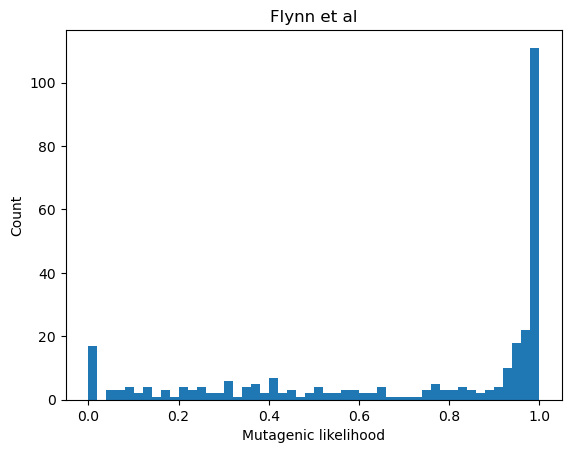

In [4]:
# check distribution.
plt.hist(fn_scores, bins=50)
plt.title("Flynn et al")
plt.ylabel("Count")
plt.xlabel("Mutagenic likelihood")
plt.show()

In [5]:
scores_df_fret["functional score"]

4       1.050044
22      1.005188
21      1.017522
20      1.044105
19      0.998277
          ...   
6031    1.007102
6030    0.973555
6047     0.99052
6038    1.029515
6048    0.860178
Name: functional score, Length: 5743, dtype: object

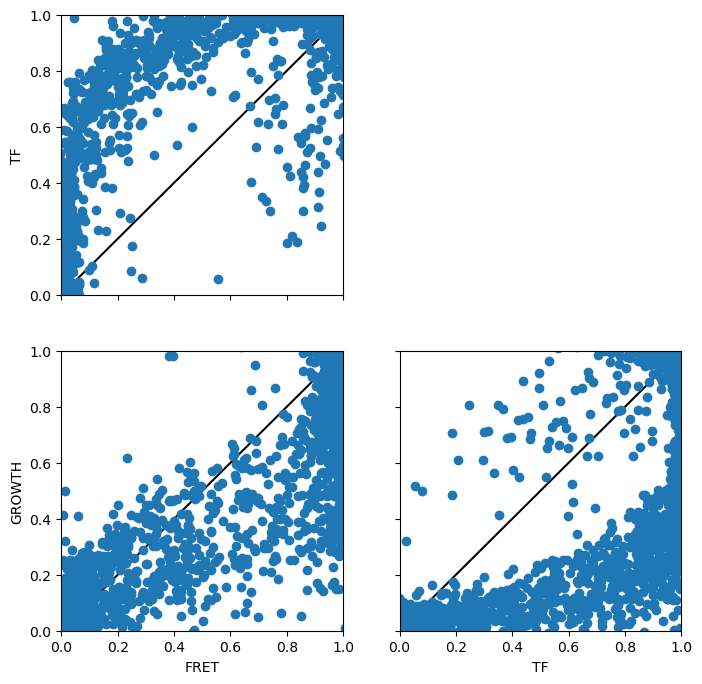

In [7]:
# check inter-assay correlations.
fn_scores_fret, scores_df_fret = getFlynn(assay="fret", sep="\t")
fn_scores_tf, scores_df_tf = getFlynn(assay="tf", sep=",")
fn_scores_growth, scores_df_growth = getFlynn(assay="growth", sep=",")

# get and merge all scores to ensure equal array length.
scores_df_fret.rename(columns={'functional score': 'functional score_fret'}, inplace=True)
scores_df_tf.rename(columns={'functional score': 'functional score_tf'}, inplace=True)
scores_df_growth.rename(columns={'functional score': 'functional score_growth'}, inplace=True)
pd.concat([scores_df_fret, scores_df_tf, scores_df_growth])
merged = scores_df_fret.merge(scores_df_tf, on=["Position", "aa"], how='inner', suffixes=('_1', '_2'))
merged_3assays = merged.merge(scores_df_growth, on=["Position", "aa"], how='inner', suffixes=('_1', '_2'))

# now plot.
f, axes = plt.subplots(2,2, figsize=(8,8), sharey=True, sharex=True)

axes[0][0].scatter(merged_3assays["functional score_fret"], merged_3assays["functional score_tf"])
axes[1][0].scatter(merged_3assays["functional score_fret"], merged_3assays["functional score_growth"])
axes[1][1].scatter(merged_3assays["functional score_tf"], merged_3assays["functional score_growth"])


# label axes.
axes[0][0].set_ylabel("TF")
axes[1][0].set_xlabel("FRET")
axes[1][0].set_ylabel("GROWTH")
axes[1][1].set_xlabel("TF")


# make x=y lines.
axes[0][0].plot([-10, 10], [-10, 10], color="black", zorder=-10)
axes[1][0].plot([-10, 10], [-10, 10], color="black", zorder=-10)
axes[1][1].plot([-10, 10], [-10, 10], color="black", zorder=-10)
for ax in axes.flatten():
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)
    
# last edits
axes[0][1].axis('off')
plt.show()

In [8]:
# bloom et al
bloom = pd.read_csv("../data/mpro_mutations_map.csv")

# squash per residue using mean. might have to change this later bc
# ceil/floor of arrays is more important in mutations?
count_scores = []
for residue_number, data in bloom.groupby(by="Mpro residue"):
    count_score = data["count"].mean()
    count_scores.append(count_score)

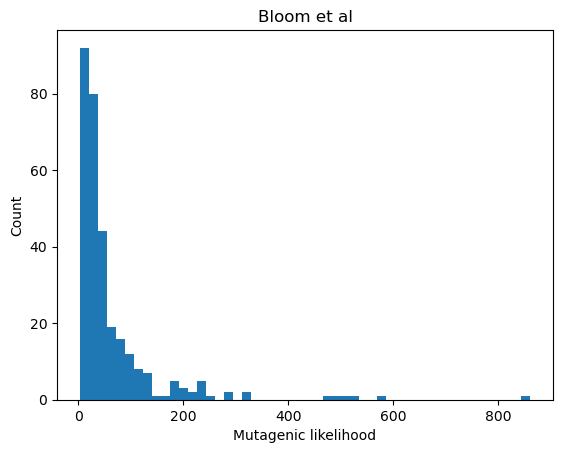

In [9]:
# check distribution.
plt.hist(count_scores, bins=50)
plt.title("Bloom et al")
plt.ylabel("Count")
plt.xlabel("Mutagenic likelihood")
plt.show()

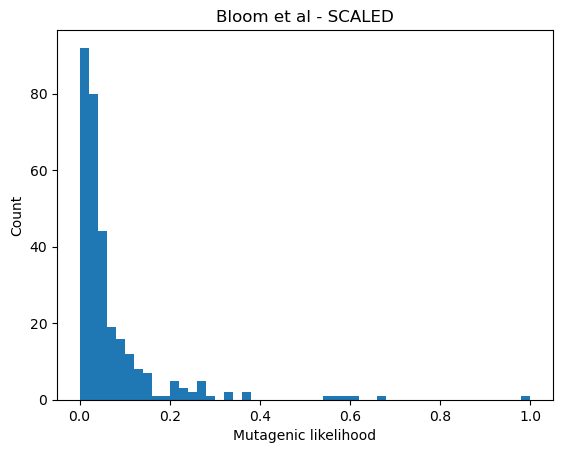

In [10]:
# check distribution: scaled to 0-1.
count_scores_scaled = (count_scores - np.min(count_scores))/np.ptp(count_scores)
plt.hist(count_scores_scaled, bins=50)
plt.title("Bloom et al - SCALED")
plt.ylabel("Count")
plt.xlabel("Mutagenic likelihood")
plt.show()

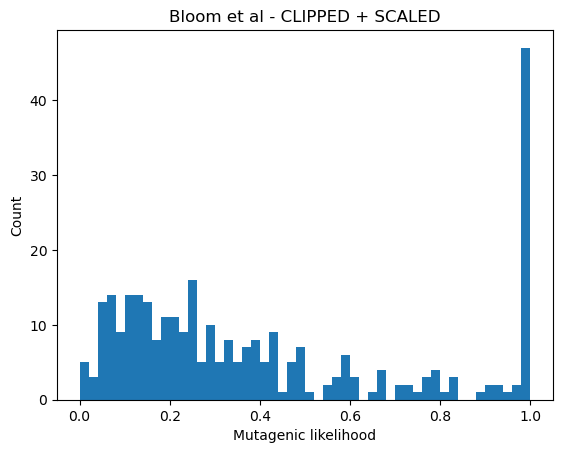

In [11]:
# outliers mess up color mapping on complex - clip them.
count_scores_clipped = np.clip(count_scores, min(count_scores), 100)

# check distribution: scaled to 0-1.
count_scores_clipped_scaled = (count_scores_clipped - np.min(count_scores_clipped))/np.ptp(count_scores_clipped)
plt.hist(count_scores_clipped_scaled, bins=50)
plt.title("Bloom et al - CLIPPED + SCALED")
plt.ylabel("Count")
plt.xlabel("Mutagenic likelihood")
plt.show()

## How well do the two datasets correlate?

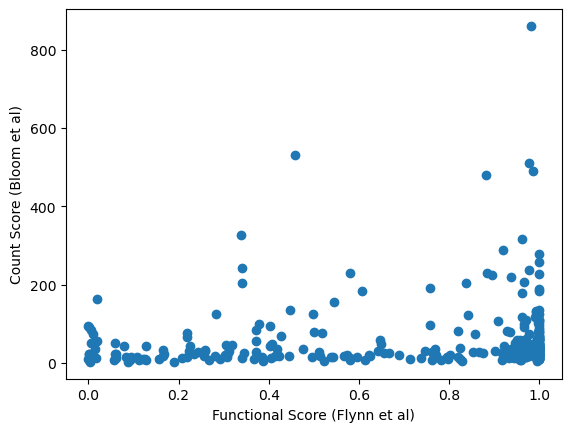

In [12]:
plt.scatter(fn_scores, count_scores)
plt.xlabel("Functional Score (Flynn et al)")
plt.ylabel("Count Score (Bloom et al)")
plt.show()

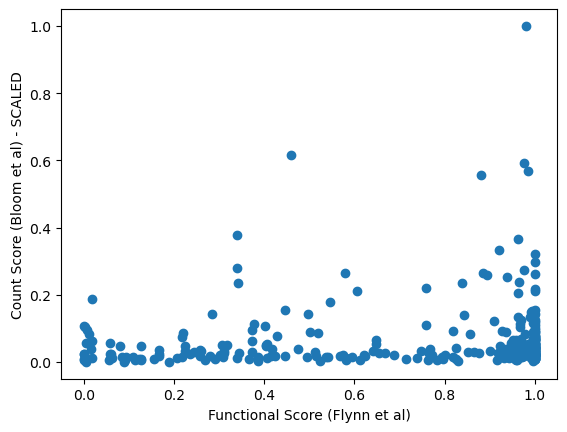

In [13]:
plt.scatter(fn_scores, count_scores_scaled)
plt.xlabel("Functional Score (Flynn et al)")
plt.ylabel("Count Score (Bloom et al) - SCALED")
plt.show()

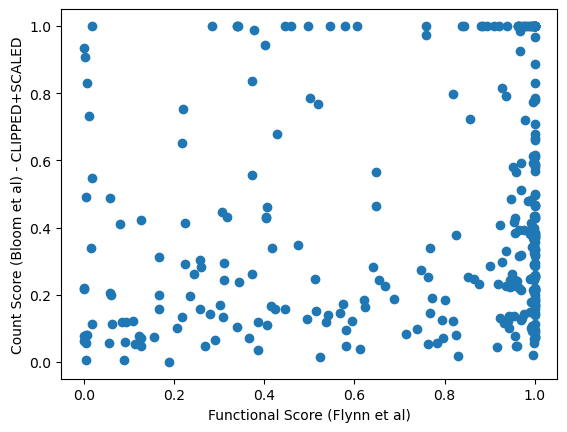

In [14]:
plt.scatter(fn_scores, count_scores_clipped_scaled)
plt.xlabel("Functional Score (Flynn et al)")
plt.ylabel("Count Score (Bloom et al) - CLIPPED+SCALED")
plt.show()

## Find dataset interphase

In [15]:
bloom_small = bloom[["Mpro residue", "orig", "mutation", "count"]]
scores_df_fret = merged_3assays.rename(columns={"aa" : "orig", "Position" : "Mpro residue"})
interphase_df = bloom_small.merge(scores_df_fret, on=["orig", "Mpro residue"], how="inner")
interphase_df = interphase_df.drop(["count", "Counts (uncut)_1", "Counts (uncut)_2", 
                                    "Counts (cut)_1", "Counts (cut)_2",
                                    "Counts (0 hours)", "Counts (16 hours)"
                                   ], axis=1)

print(f"Dataset interphase size: n={len(interphase_df)}; {len(interphase_df)/len(scores_df_fret)*100:.2f}% ({len(bloom_small)} & {len(scores_df_fret)})")


print(interphase_df)

# reduce column clutter.
interphase_df['mutation_path'] = interphase_df['orig'] + interphase_df['mutation']
interphase_df = interphase_df[["Mpro residue", "mutation_path", "functional score_fret"]]
interphase_df = interphase_df.astype({"Mpro residue": int, "mutation_path": str, "functional score_fret": float})


interphase_df


Dataset interphase size: n=438; 7.64% (2195 & 5731)
     Mpro residue orig mutation functional score_fret functional score_tf  \
0               7    T        A              1.017934            0.997487   
1               7    V        A              0.994774            1.001245   
2               8    L        F              0.947065            1.002037   
3              10    A        S             -0.007758           -0.023863   
4              12    R        K              1.013701            1.007258   
..            ...  ...      ...                   ...                 ...   
433           297    I        V              1.034355            0.979676   
434           301    L        *              1.011444            1.007258   
435           303    I        V              0.918276            0.495027   
436           304    I        T              0.978854            1.007258   
437           305    S        F              1.014167            1.007258   

    functional score_gr

,Mpro residue,mutation_path,functional score_fret
0,7,TA,1.017934
1,7,VA,0.994774
2,8,LF,0.947065
3,10,AS,-0.007758
4,12,RK,1.013701
...,...,...,...
433,297,IV,1.034355
434,301,L*,1.011444
435,303,IV,0.918276
436,304,IT,0.978854


In [16]:
plot_array = interphase_df.pivot(columns="Mpro residue", index="mutation_path").values


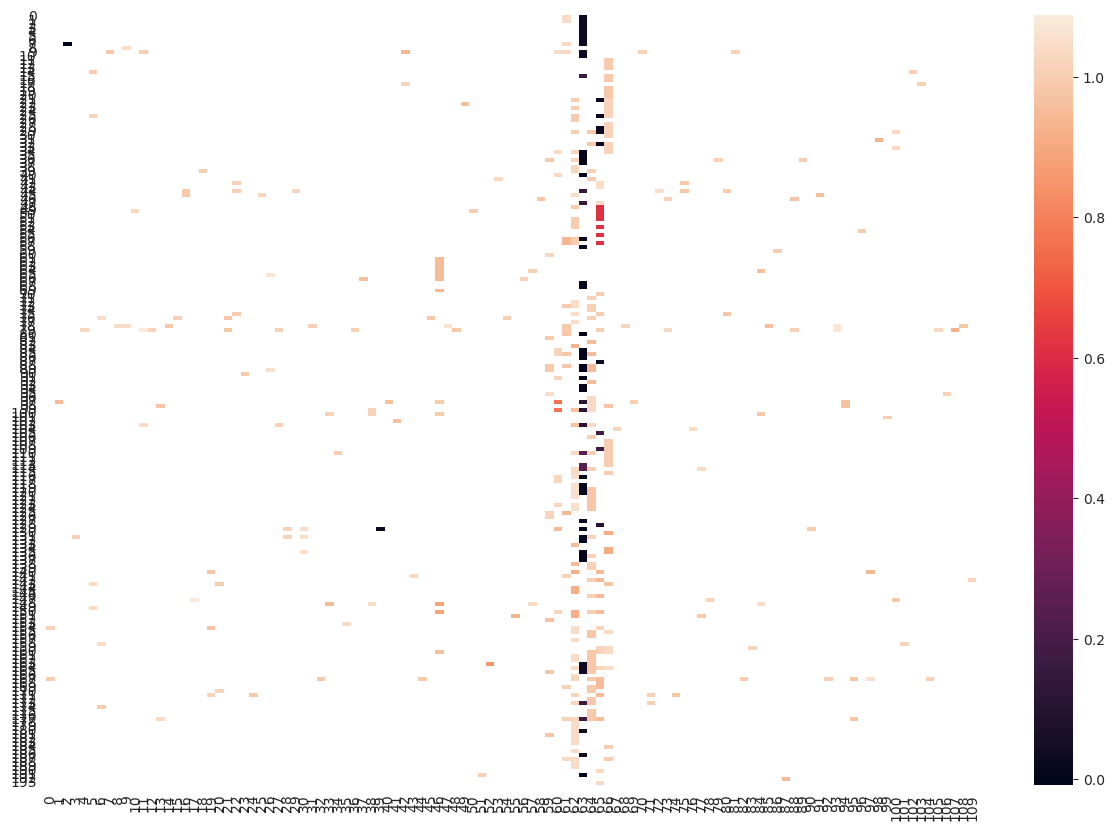

In [17]:
# now heatmap showing for each res the possible mutations (bloome et al) and color showing functional score (flynn et al)
plt.figure(figsize=(15, 10))

with sns.axes_style("white"):
    sns.heatmap(plot_array, xticklabels=1, yticklabels=1)
    

Not great. Reduce dimensionality by showing as grouped barplots?

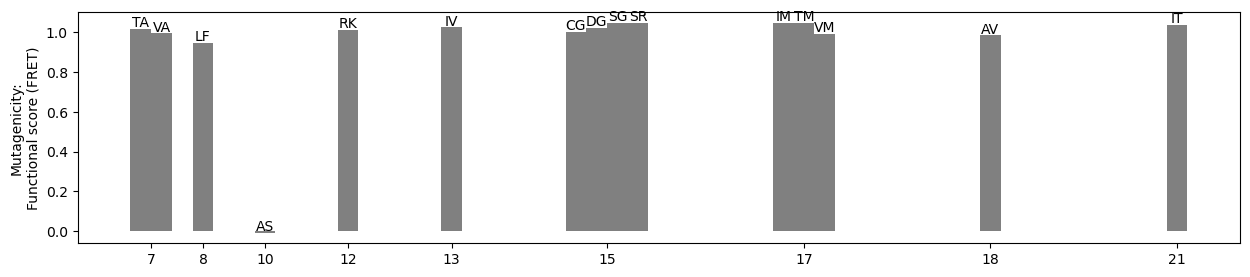

In [21]:
barplot_df = interphase_df[:15]



barplot_df = barplot_df.pivot(columns="mutation_path", index="Mpro residue", values="functional score_fret")
barplot_df = barplot_df.sort_values(by="Mpro residue")
barplot_df.index.map(str)


# df = pd.DataFrame(
#     {"foo": [1, None, None], "bar": [None, 2, 0.5], "col": [1, 1.5, None]},
#     index=["A", "B", "C"],
# )

fig = plt.figure(figsize=(15, 3))
ax = plt.gca()

# width of bars
width = 1

# create emptly lists for x tick positions and names
x_ticks, x_ticks_pos = [], []

# counter for helping with x tick positions
count = 0

# reset the index
# so that we can iterate through the numbers.
# this will help us to get the x tick positions
barplot_df = barplot_df.reset_index()
# go through each row of the dataframe
annot_x_ticks_pos = []
annot_y_ticks_pos = []
for idx, row in barplot_df.iterrows():
    # this will be the first bar position for this row
    count += idx

    # this will be the start of the first bar for this row
    start_idx = count - width / 2
    # this will be the end of the last bar for this row
    end_idx = start_idx
    # for each column in the wanted columns,
    # if the row is not null,
    # add the bar to the plot
    # also update the end position of the bars for this row
    for column in barplot_df.drop(["Mpro residue"], axis=1).columns:
        if row[column] == row[column]:
            plt.bar(count, row[column], color="gray", width=width, label=column)
            
            annot_x_ticks_pos.append(count)
            annot_y_ticks_pos.append(row[column])
            
            count += 1
            end_idx += width
    # this checks if the row had any not NULL value in the desired columns
    # in other words, it checks if there was any bar for this row
    # if yes, add the center of all the row's bars and the row's name (A,B,C) to the respective lists
    if end_idx != start_idx:
        x_ticks_pos.append((end_idx + start_idx) / 2)
        x_ticks.append(row["Mpro residue"])

# now set the x_ticks
x_ticks = [ int(tick) for tick in x_ticks ]
plt.xticks(x_ticks_pos, x_ticks)

# set mutation annotations.
handles, labels = plt.gca().get_legend_handles_labels()

for x, y, mutation in zip(annot_x_ticks_pos, annot_y_ticks_pos, labels):
    
    plt.annotate(mutation, xy=(float(x), float(y)+0.01), ha="center")

    
    
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

plt.ylabel("Mutagenicity:\nFunctional score (FRET)")

plt.show()

Perhaps numerical would be enough for a pipeline, i.e. just combine the two datasets by picking residues with high number of highly functional mutations?

## Show functional scores on complex

In [22]:
def show_colorbar(gradient_scheme, bins, label):
    fig, ax = plt.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)

    cmap = mpl.colors.ListedColormap(gradient_scheme)
    # cmap.set_over('0.25')
    # cmap.set_under('0.75')

    bounds = bins
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                    norm=norm,
    #                                 boundaries=[0] + bounds + [13],
    #                                 extend='both',
                                    ticks=bounds,
                                    spacing='proportional',
                                    orientation='horizontal')
    cb2.set_label(label)
    plt.show()

In [23]:
def show_residues_around(view, component_index=0, selection="ligand", radius=5.0):
    # focus view on ligand
    js = (
        f"""
        // Get first (and only) loaded component: our protein-ligand system
        var system = this.stage.compList[{component_index}];
        // Store current selection, we will need it laer
        var prevSele = system.selection.string;
        // Set selection to our desired ligand
        system.setSelection("{selection}");
        // Select all atoms within 5A from the ligand
        var around = system.structure.getAtomSetWithinSelection(system.selection, {radius});
        """
        """
        // Extend selection so it includes full residues
        var around_complete = system.structure.getAtomSetWithinGroup(around);
        // Add representation for those atoms
        system.addRepresentation("licorice", {sele: around_complete.toSeleString()});
        // Restore selection to original one; otherwise changes won't be reflected
        system.setSelection(prevSele)
        """
    )
    view._execute_js_code(js)

In [24]:
def buildColorScheme(label_array, scheme_name):
    # make a color registry for NGLview based on functional scores.
    # first set the gradient hex colors. Made using the amazing https://colordesigner.io/gradient-generator
    gradient_scheme =  [
                        "#6eb0fa",
                        "#79a5f5",
                        "#859aee",
                        "#928ee5",
                        "#9e81d9",
                        "#a874cc",
                        "#b266bc",
                        "#b958aa",
                        "#be4997",
                        "#c03a82",
                        "#c02a6d",
                        ]
    # now create a nested list in the way that NGLview likes it, i.e. [["color_n", "idx_n"], ["color_n+1", "idx_n+1"]].
    # numpy can determine which bin each value belongs in.
    bin_idces = np.digitize(label_array, np.linspace(min(label_array), max(label_array), 11))
    bin_idces = [ idc-1 for idc in bin_idces ] # arrays start at 0 tyvm

    # build the color scheme.
    color_scheme = []
    for res_num, idx in enumerate(bin_idces):
        color_scheme.append([gradient_scheme[idx], str(res_num)])
    nv.color.ColormakerRegistry.add_selection_scheme(
        scheme_name, color_scheme)
    
    return color_scheme, scheme_name, gradient_scheme

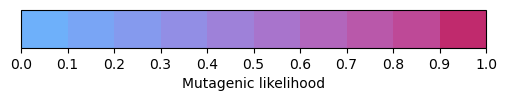

Flynn et al


NGLWidget()

In [25]:
# load protein complex with first ligand, but hide it all.
view = nv.show_file("../data/Mpro-P1788_0A_bound.pdb", default_representation=False) 

# add high-quality surface of protein.
color_scheme, scheme_name, color_wheel = buildColorScheme(fn_scores, "functional score")
view.add_surface("protein", color=scheme_name, surfaceType="av")

# add the ligand.
view.add_ball_and_stick("ligand")
show_residues_around(view)

# add a second ligand to compare poses. This needs to be aligned.
view.add_component("../data/7vh8_paxlovid_aligned_lig.pdb")
view.clear(component=1)
view.add_ball_and_stick(component=1, color="cyan")
view.center()

# show cbar and display nglwidget.
show_colorbar(color_wheel, np.linspace(0, 1, 11), "Mutagenic likelihood")
print("Flynn et al")
view

Bloom et al


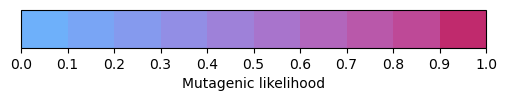

NGLWidget()

In [26]:
# load protein complex with first ligand, but hide it all.
view = nv.show_file("../data/Mpro-P1788_0A_bound.pdb", default_representation=False) 

# add high-quality surface of protein.
color_scheme, scheme_name, color_wheel = buildColorScheme(count_scores_clipped_scaled, "mutation_count")



view.add_surface("protein", color=scheme_name, surfaceType="av")

# add the ligand.
view.add_ball_and_stick("ligand")
show_residues_around(view)

# add a second ligand to compare poses. This needs to be aligned.
view.add_component("../data/7vh8_paxlovid_aligned_lig.pdb")
view.clear(component=1)
view.add_ball_and_stick(component=1, color="cyan")

view.center()
print("Bloom et al")


# show cbar and display nglwidget.
show_colorbar(color_wheel, np.linspace(0, max(count_scores_clipped_scaled), 11), "Mutagenic likelihood")
view